<h1 align=center><font size = 8>Situación Covid-19 en Galicia</font></h1>

El propósito de este notebook es capturar de la <a href="https://coronavirus.sergas.gal/datos/#/gl-ES/undefined">web del Sergas</a> los datos actualizados de la situación de Galicia frente al Covid-19, y posteriormente realizar algunos análisis básicos, guardando los resultados en directorios.

Para los cálculos basados en el número de habitantes se emplea un fichero csv obteniendo mediante otro notebook, llamado _Población Areas_ y también disponible en el repositorio de GitHub. Se debe de tener en cuenta que en este análisis se trabaja con áreas sanitarias y no con ayuntamientos. Pese a que todos los nombres de las áreas sanitarias coinciden también con nombres de ayuntamientos, en ellas se encuentran englobadas otras comarcas y ayuntamientos limítrofes y próximas.

In [1]:
from classes.covid19galicia import covid19galicia
import pandas as pd

# 1. Importación de datos

Creamos la clase que maneja los datos de la web del Sergas e importamos solamente aquellos que son necesarios para las futuras gráficas.

In [2]:
galicia = covid19galicia()
casos_activos = galicia.getCifrasTotais()
infectados_fecha = galicia.getInfeccionesPorFecha()
camas = galicia.getOcupacionCamas()
fallecidos = galicia.getActivosCuradosFallecidos()
inc14 = galicia.getIncidenciaConcello()

Ultima actualización: 2021-06-29


Podemos visualizar los datos del último día:

In [3]:
total = galicia.getCifrasTotais()
print('En las últimas 24h hubo {} casos en Galicia'.format(total['Casos_Confirmados_PDIA_Ultimas24h'].sum()))
total

En las últimas 24h hubo 157 casos en Galicia


,Fecha,Area_Sanitaria,Casos_Totais,Casos_Confirmados_PDIA_Ultimas24h,Pacientes_Sin_Alta,Pacientes_Con_Alta,Camas_Ocupadas_HOS,Camas_Ocupadas_UCI,Probas_Realizadas_PCR,Probas_Realizadas_Non_PDIA,Exitus,Probas_Antixenos_Realizadas
0,2021-06-29,A Coruña,31178,34,512,30081,27,3,533039,154458,600,188584
1,2021-06-29,Ferrol,8758,9,76,8459,1,1,151664,62327,217,16535
2,2021-06-29,Lugo,13244,19,206,12817,3,2,260697,137246,216,43466
3,2021-06-29,Ourense,16019,16,168,15434,5,0,267760,133246,418,76421
4,2021-06-29,Pontevedra,14644,31,262,14201,6,3,248718,93563,181,85834
5,2021-06-29,Santiago,20262,15,164,19745,1,1,374676,147198,365,101464
6,2021-06-29,Vigo,25533,33,285,24817,1,0,524677,271348,439,72175


# 2. Análisis

## 2.1. Casos activos - Total por área sanitaria

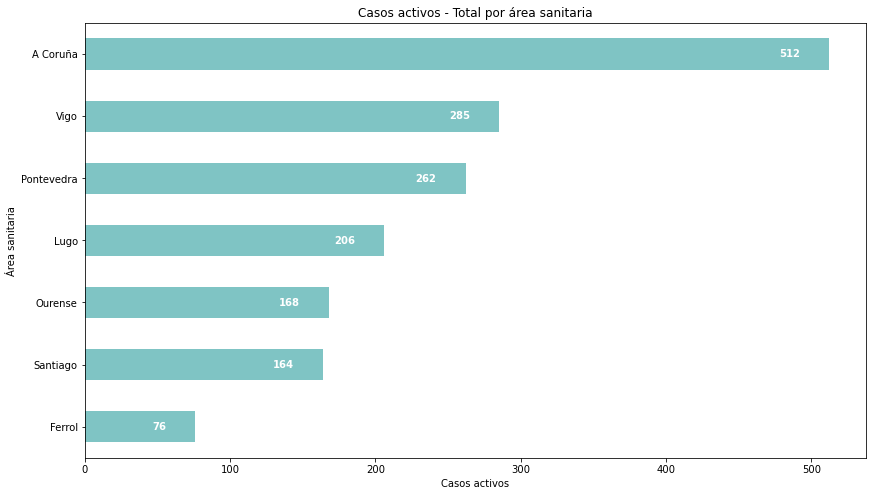

In [4]:
galicia.plotCasosActivos(casos_activos, cienmil=False)

## 2.2. Casos activos - Porcentaje por área sanitaria

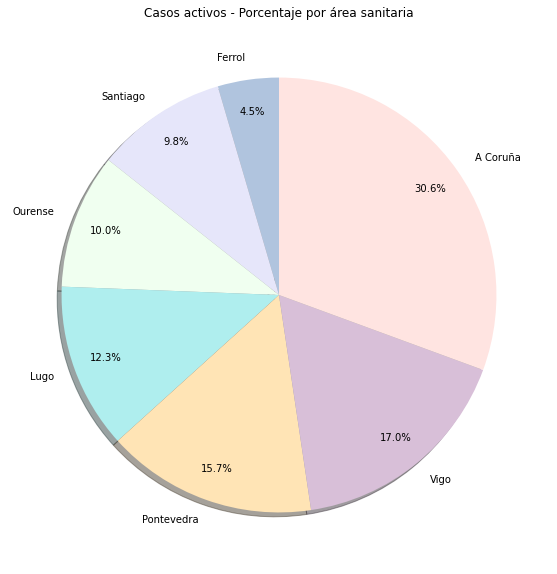

In [5]:
galicia.plotPorcentajeAreas(casos_activos)

## 2.3. Positivos

### 2.3.1. Evolución positivos acumulados últimos 7 días

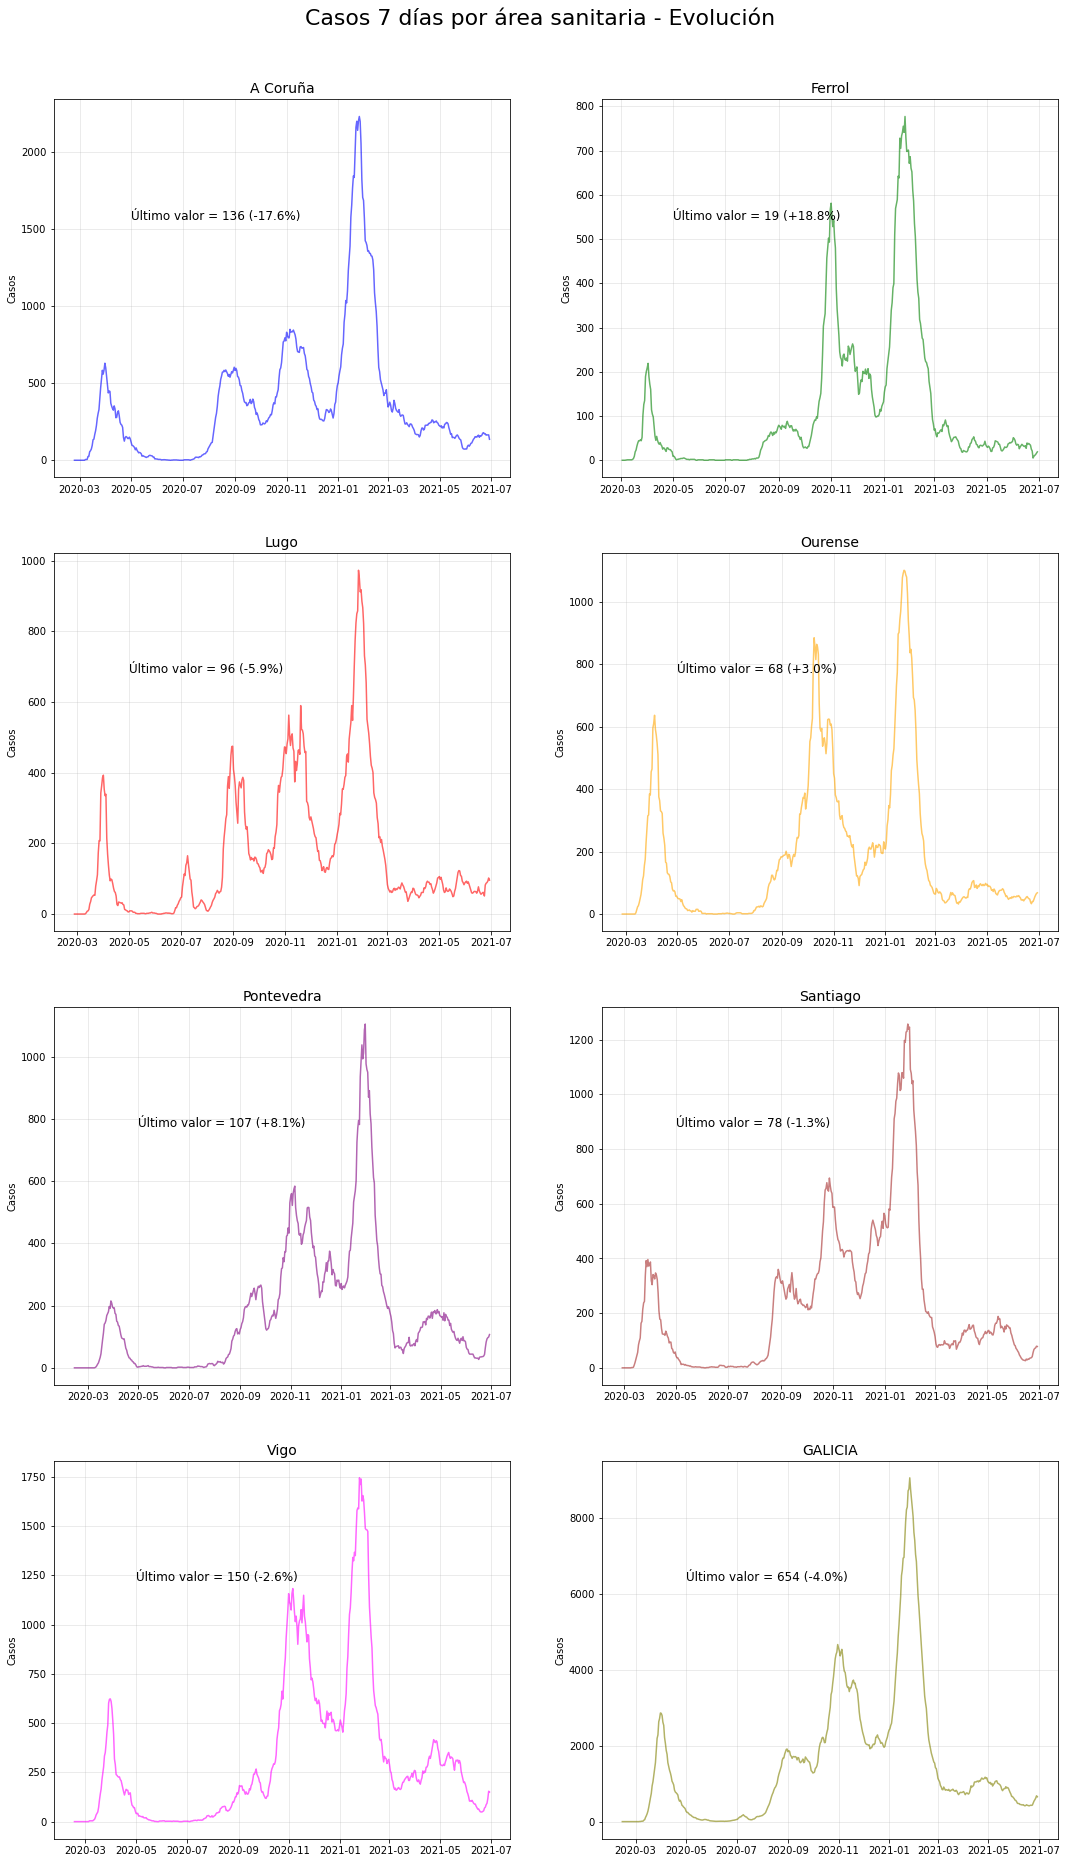

In [6]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=7)

### 2.3.2. Comparativo positivos acumulados últimos 7 días

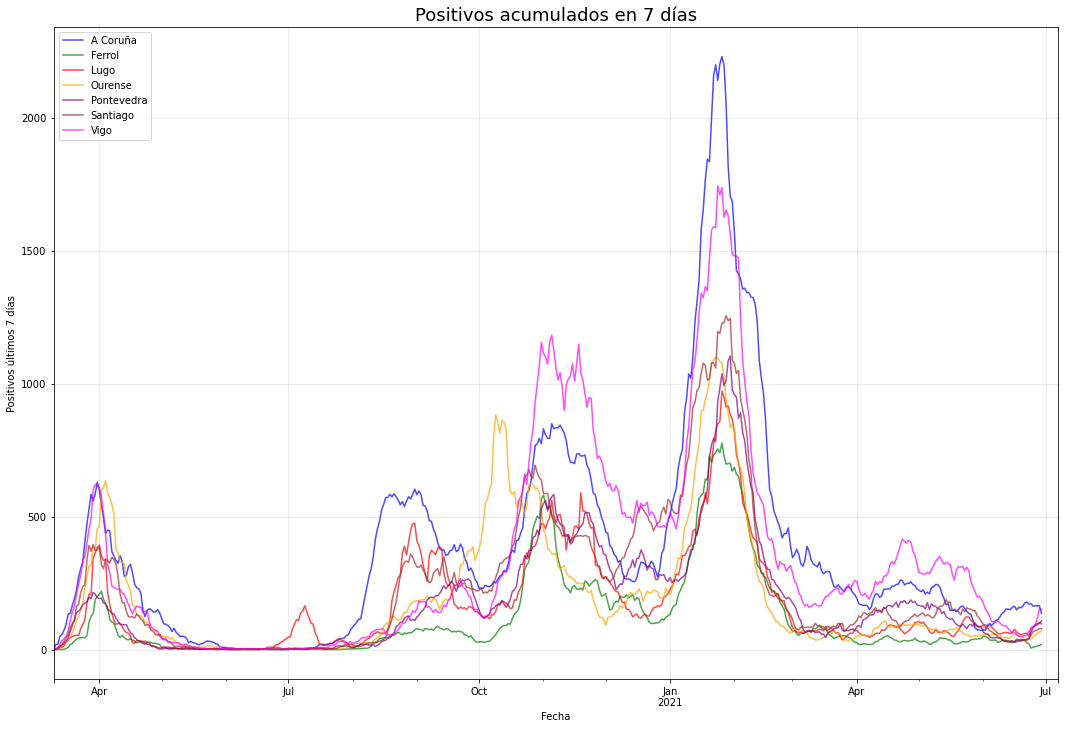

In [7]:
galicia.plotCombinado(infectados_fecha)

### 2.3.3. Principales ciudades - Incidencia 14 días / 100.000 habitantes

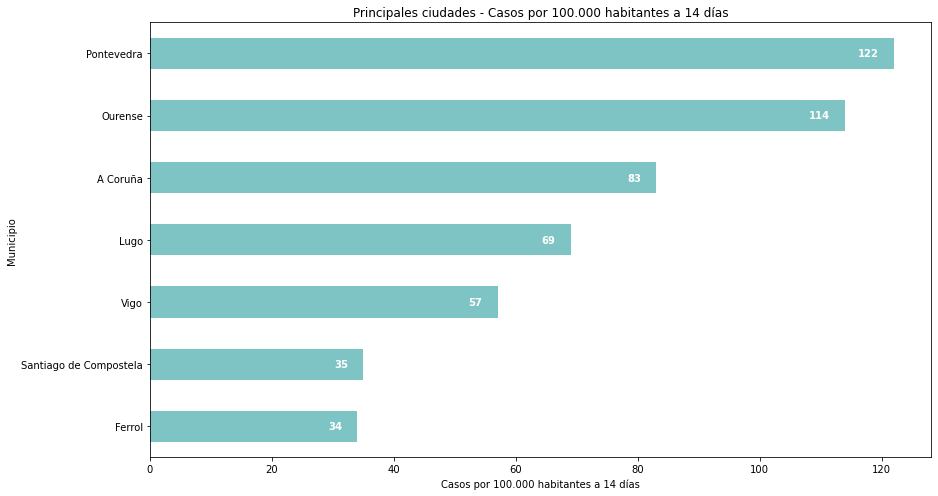

In [8]:
galicia.plotIncidenciaAcumulada(inc14, 'ciudades')

### 2.3.4. Top 10 municipios con mayor incidencia 14 días / 100.000 habitantes

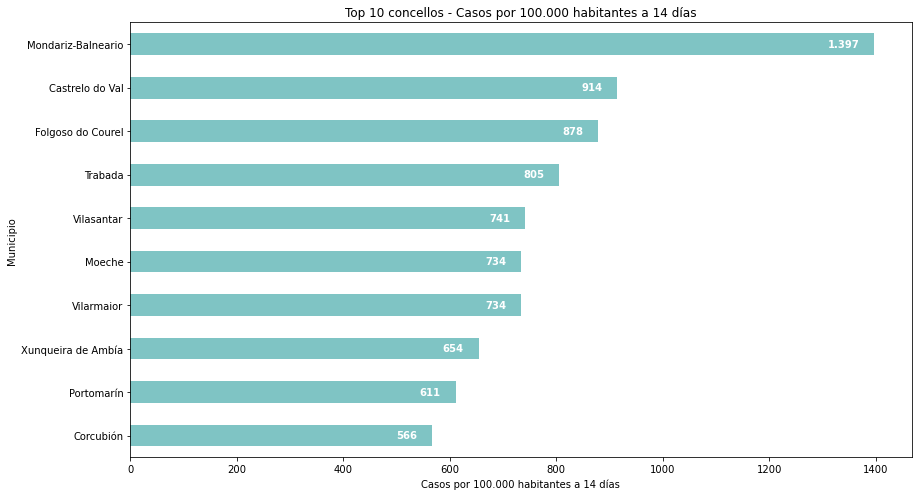

In [9]:
galicia.plotIncidenciaAcumulada(inc14, 'top10')

## 2.4. Evolución PCR acumuladas 7 días

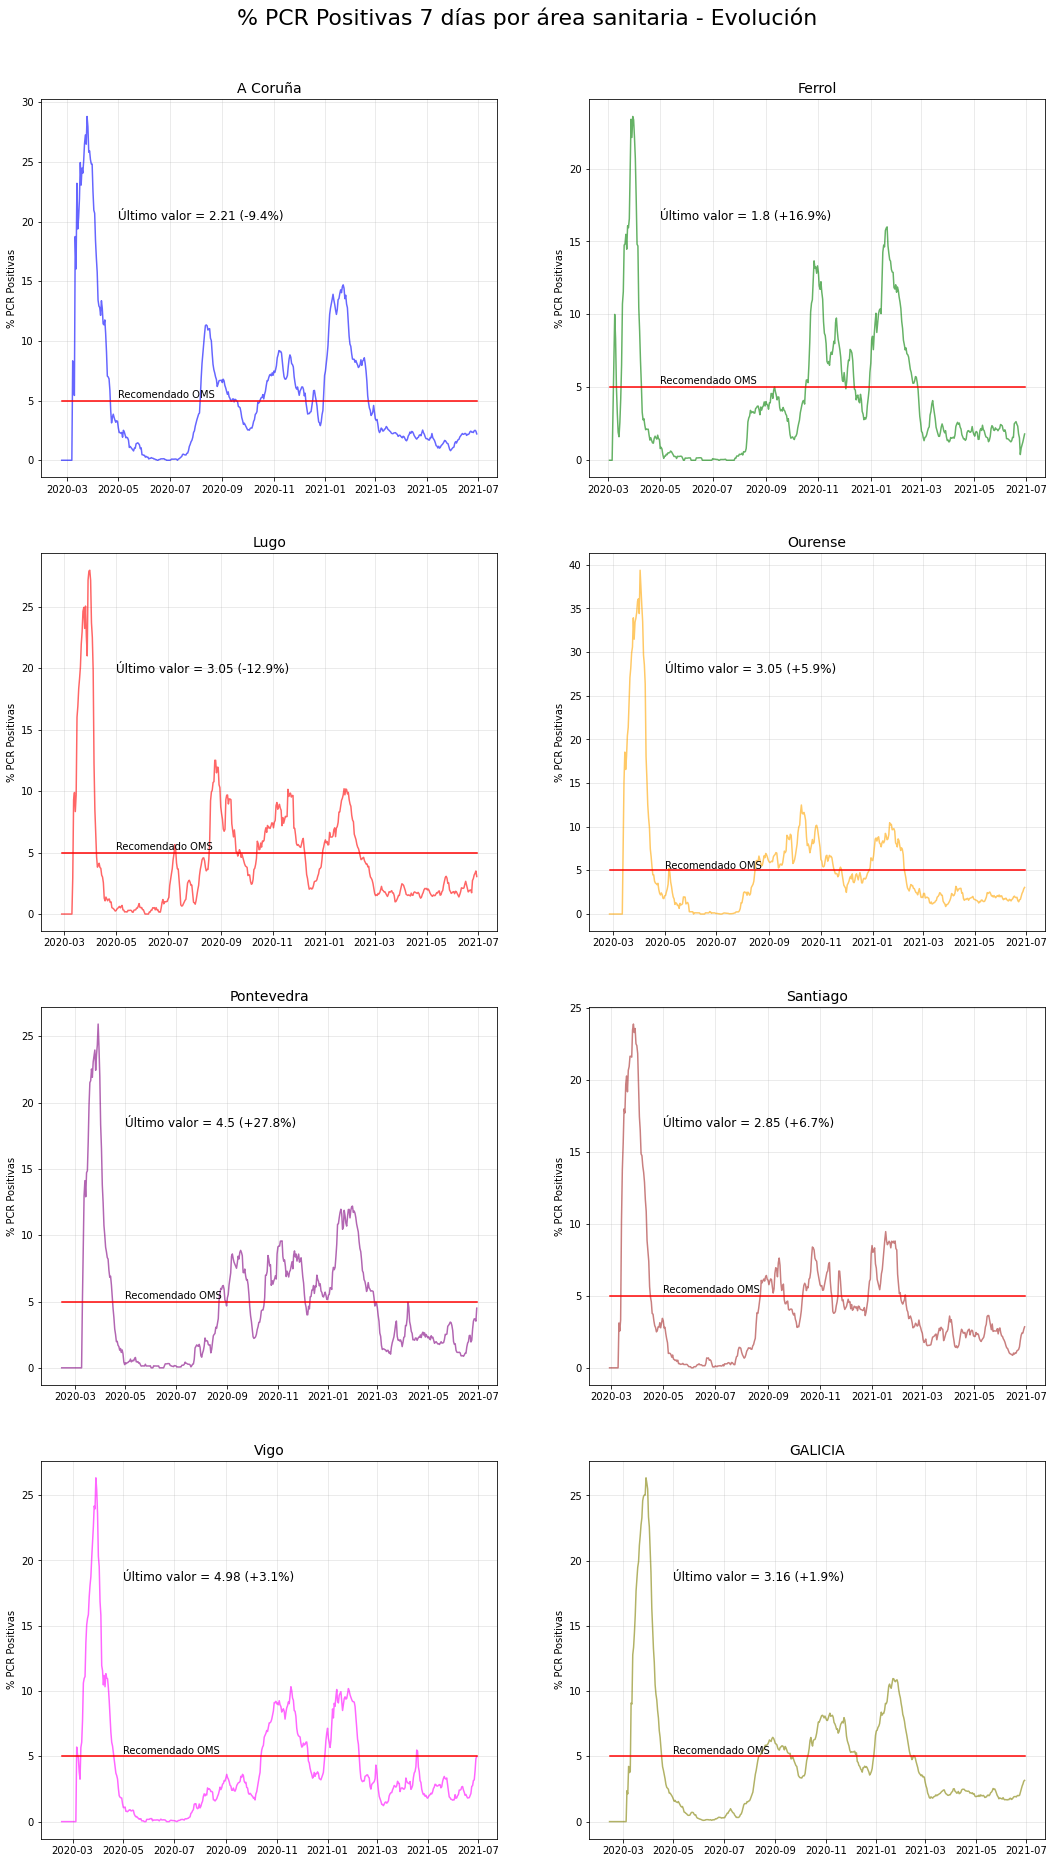

In [10]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=7)

## 2.5. Tendencias

### 2.5.1. Clara tendencia en aumento

In [11]:
inc14 = inc14[inc14['Tendencia'].notna()]
inc14 = inc14[inc14['Casos7'] != inc14['Casos']]
inc14.sort_values('Tendencia', ascending=False)
incrementos = list(inc14['Municipio'][inc14['Tendencia'] > 10])
incrementos.sort()
print(*incrementos, sep=', ')

A Laracha, Ames, Barbadás, Betanzos, Cambados, Carballo, Carnota, Castroverde, Culleredo, Lugo, Marín, Miño, Narón, Oroso, Ourense, Poio, Pontevedra, Redondela, Santiago de Compostela, Sanxenxo, Sarria, Vigo, Vilagarcía de Arousa, Vilanova de Arousa


### 2.5.2. Clara tendencia en descenso

In [12]:
descensos = list(inc14['Municipio'][inc14['Tendencia'] < -10])
descensos.sort()
print(*descensos, sep=', ')

A Pontenova, Abegondo, Bergondo, Camariñas, Cambre, Cartelle, Celanova, Cervo, Fene, Ferrol, Folgoso do Courel, Guitiriz, Guntín, Lalín, Lobios, Mazaricos, Melide, Mesía, Moeche, Monfero, Monterroso, Mugardos, Negreira, O Corgo, O Pereiro de Aguiar, Oleiros, Ortigueira, Padrón, Pol, Pontecesures, Pontedeume, Portomarín, San Sadurniño, Trabada, Vilamartín de Valdeorras, Vilarmaior


## 2.6. Ocupación actual de camas

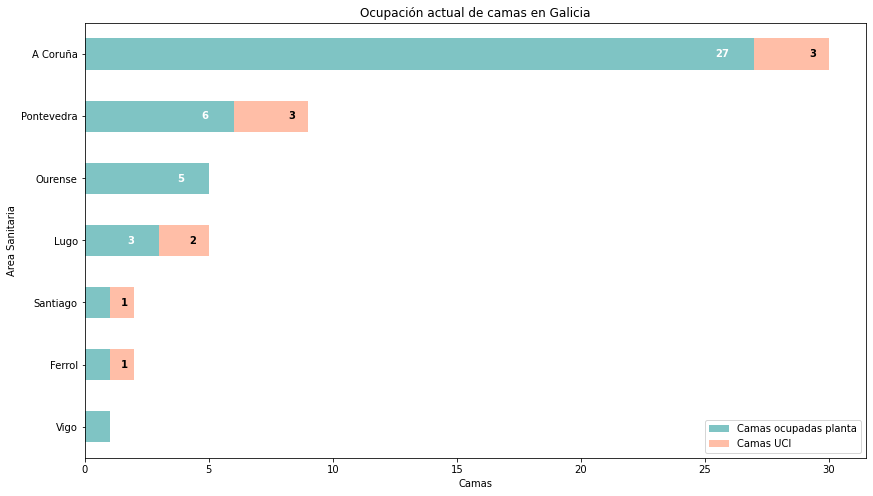

In [13]:
galicia.plotOcupacionCamas(camas)

## 2.7. Fallecidos

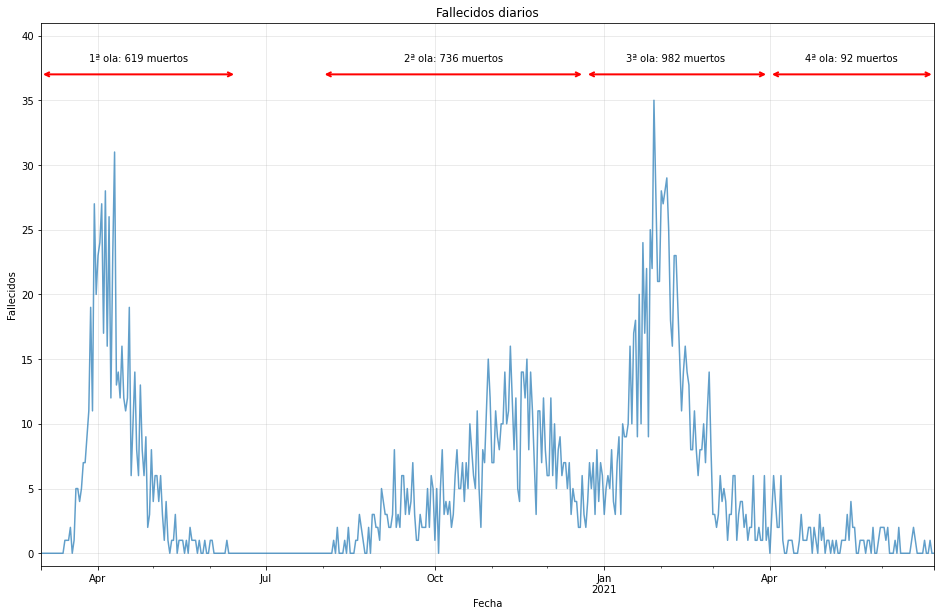

In [14]:
galicia.plotFallecidos(fallecidos)